## Imports

In [1]:
# Biology
import scanpy as sc
import anndata as ad
import muon as mu

In [2]:
# Maths
import pandas as pd
import numpy as np
import torch
from torch import optim
from umap import UMAP

In [3]:
# Our packages
from scmiot import models, pl, tl

In [4]:
import matplotlib.pyplot as plt

## Load data

In [5]:
mdata = mu.read_h5mu('../datasets/Liu/preprocessed/liu.h5mu.gz')
rna = mdata.mod['rna']
atac = mdata.mod['atac']

## Varying genes

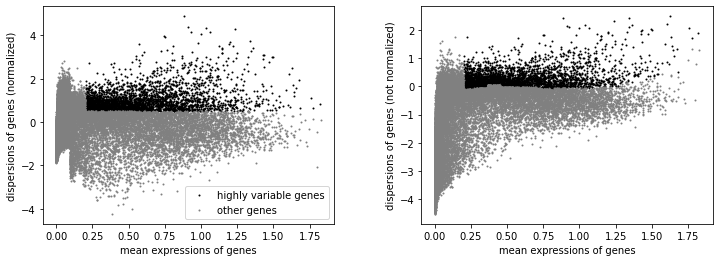

2944

In [6]:
# Highly variable genes
sc.pp.highly_variable_genes(rna, min_mean=0.2, max_mean=4, min_disp=0.5)
sc.pl.highly_variable_genes(rna)
np.sum(rna.var.highly_variable)

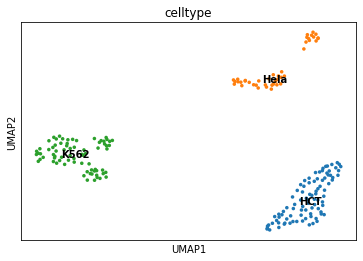

In [7]:
# Umap
sc.pp.scale(rna, zero_center=False)
sc.tl.pca(rna, svd_solver='arpack')
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=10)
sc.tl.umap(rna, spread=1.5, min_dist=.5)
sc.pl.umap(rna, color="celltype", legend_loc="on data", size=50)

## Preprocess ATAC

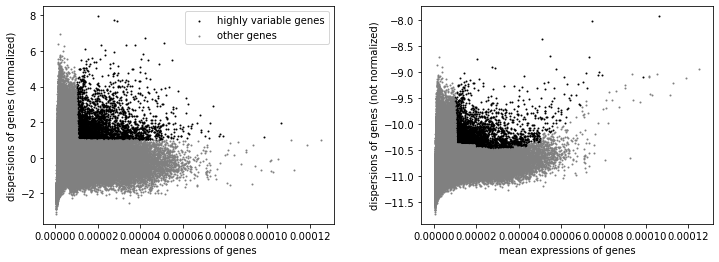

3307

In [8]:
sc.pp.highly_variable_genes(atac, min_mean=1e-5, max_mean=4, min_disp=1)
sc.pl.highly_variable_genes(atac)
np.sum(atac.var.highly_variable)

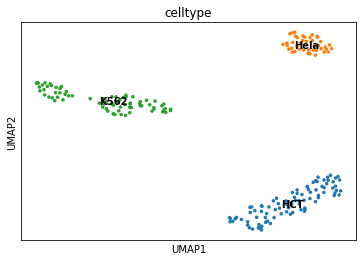

In [9]:
# Umap
sc.pp.scale(atac, zero_center=False)
sc.tl.pca(atac, svd_solver='arpack')
sc.pp.neighbors(atac, n_neighbors=10, n_pcs=10)
sc.tl.umap(atac, spread=1.5, min_dist=.5)
sc.pl.umap(atac, color="celltype", legend_loc="on data", size=50)

## OT NMF

In [10]:
eps = .1
latent_dim = 5
rho = .075

In [11]:
nmf = models.OTintNMF(latent_dim=latent_dim, rho_h=rho, rho_w=rho, lr=1e-2, eps=eps)

In [12]:
nmf.fit_transform(mdata, cost='cosine', n_iter_inner=20, n_iter=10, device='cpu')

 90%|█████████ | 720/800 [02:39<00:17,  4.65it/s, loss=532.1025] 

## Convergence plots

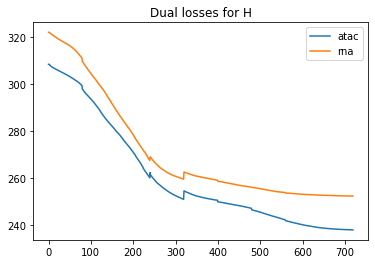

 90%|█████████ | 720/800 [02:39<00:17,  4.51it/s, loss=532.1025]


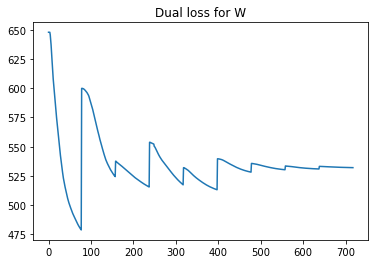

In [13]:
nmf.plot_convergence()

## Viz

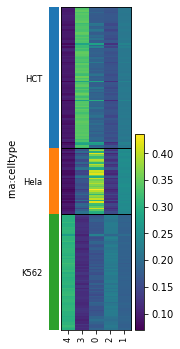

In [14]:
pl.heatmap(mdata, 'W_OT', 'rna:celltype')

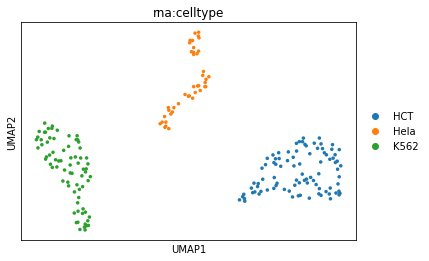

In [15]:
pl.umap(mdata, 'W_OT', 'rna:celltype')

## Add more dimensions

In [16]:
latent_dim += 5
nmf.update_latent_dim(mdata, latent_dim, n_iter_inner=20, n_iter=10, device='cpu')

 70%|███████   | 560/800 [02:41<01:00,  3.94it/s, loss=542.3388] 

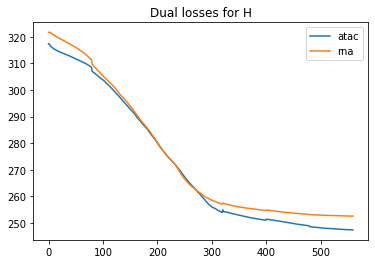

 70%|███████   | 560/800 [02:41<01:09,  3.46it/s, loss=542.3388]


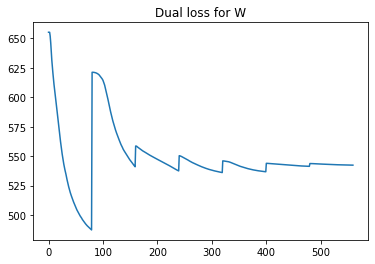

In [17]:
nmf.plot_convergence()

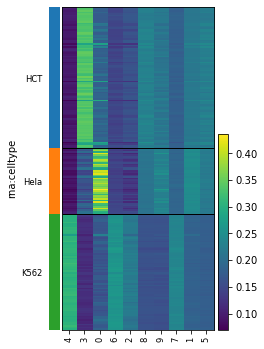

In [18]:
pl.heatmap(mdata, 'W_OT', 'rna:celltype')

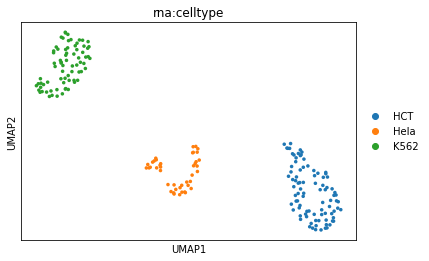

In [19]:
pl.umap(mdata, 'W_OT', 'rna:celltype')

## Clustering

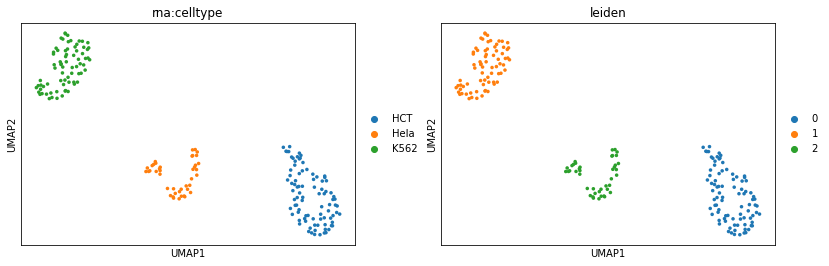

In [20]:
tl.leiden(mdata, resolution=.1)
pl.umap(mdata, 'W_OT', ['rna:celltype', 'leiden'])

## Clustering with automatic resolution

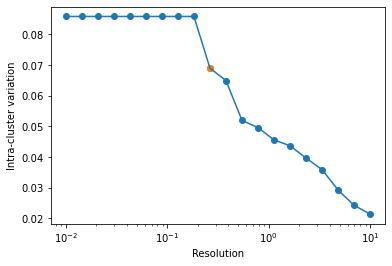

Leiden with best resolution heuristic (intra cluster variation elbow): 0.26366508987303583


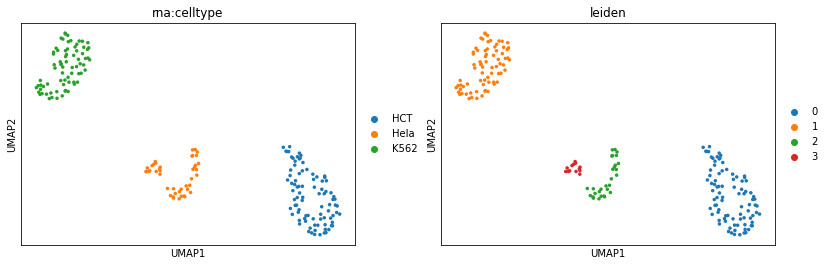

In [21]:
res = tl.best_leiden_resolution(mdata, method='elbow')
print('Leiden with best resolution heuristic (intra cluster variation elbow):', res)
tl.leiden(mdata, resolution=res)
pl.umap(mdata, 'W_OT', ['rna:celltype', 'leiden'])

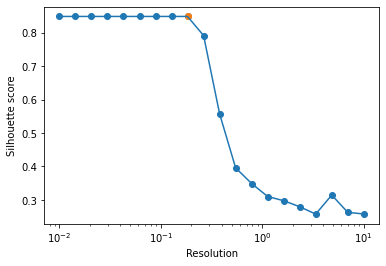

Leiden with best resolution heuristic (first local maximum silhouette): 0.18329807108324356


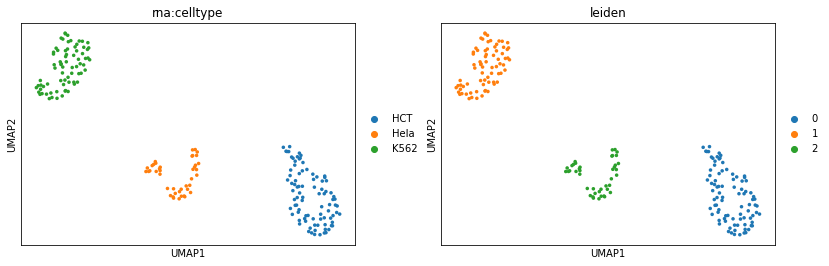

In [22]:
res = tl.best_leiden_resolution(mdata, method='silhouette')
print('Leiden with best resolution heuristic (first local maximum silhouette):', res)
tl.leiden(mdata, resolution=res)
pl.umap(mdata, 'W_OT', ['rna:celltype', 'leiden'])